<a href="https://colab.research.google.com/github/ME0ny/FakeNewsDetection/blob/master/FakeDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
pip install pytorch-transformers

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 890kB 8.3MB/s 
     |████████████████████████████████| 1.0MB 19.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=bcc9cb67fe76ba21acbf698c965412c8362529214e691d42af08b2e2c3cca10b
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


In [11]:
import pandas as pd

pos_texts = pd.read_csv('True.csv')
neg_texts = pd.read_csv('Fake.csv')
pos_texts.sample(5)

,title,text,subject,date
710,U.S. small business lobby throws support behin...,WASHINGTON (Reuters) - The National Federation...,politicsNews,"November 9, 2017"
21053,Kenya to hold new presidential vote on Oct. 17...,NAIROBI (Reuters) - Kenya will hold a new pres...,worldnews,"September 4, 2017"
16737,"Slovakia a pro-European island in its region, ...",BRATISLAVA (Reuters) - Slovakia s prime minist...,worldnews,"October 23, 2017"
2037,Fellow Republicans rebuke Trump over governmen...,WASHINGTON/NEW YORK (Reuters) - President Dona...,politicsNews,"August 23, 2017"
15290,"SpaceX to launch Turkish satellites, minister ...",ISTANBUL (Reuters) - Turkey s Turksat 5A and 5...,worldnews,"November 9, 2017"


In [0]:
sentences = np.concatenate([pos_texts['text'].values, neg_texts['text'].values])

sentences = ["[CLS] " + sentence[:509] + " [SEP]" for sentence in sentences]
labels = [[0] for _ in range(pos_texts.shape[0])] + [[1] for _ in range(neg_texts.shape[0])]


In [0]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [14]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2576675.29B/s]


['[CLS]', 'london', '(', 'reuters', ')', '-', 'u', '.', 's', '.', 'secretary', 'of', 'state', 'john', 'kerry', 'said', 'on', 'monday', 'it', 'was', '“', 'inappropriate', '”', 'for', 'donald', 'trump', 'to', 'brand', 'german', 'chancellor', 'angela', 'mer', '##kel', '’', 's', 'refugee', 'policy', '“', 'a', 'catastrophic', 'mistake', '”', '.', '“', 'i', 'thought', 'frankly', 'it', 'was', 'inappropriate', 'for', 'a', 'president', '-', 'elect', 'of', 'the', 'united', 'states', 'to', 'be', 'stepping', 'into', 'the', 'politics', 'of', 'other', 'countries', 'in', 'a', 'quite', 'direct', 'manner', ',', '”', 'kerry', 'told', 'cnn', '’', 's', 'christian', '##e', 'ama', '##np', '##our', 'during', 'a', 'one', '-', 'day', 'visit', 'to', 'london', 'in', 'the', 'last', 'week', 'of', 'the', 'obama', 'administration', '.', '“', 'he', 'will', 'have', 'to', 'speak', 'to', 'that', '.', 'as', 'of', '[SEP]']


In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [0]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [0]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [19]:
train_labels

tensor([[1],
        [1],
        [0],
        ...,
        [0],
        [1],
        [1]])

In [20]:
print(validation_labels)

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])


In [21]:
validation_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [22]:
validation_inputs

tensor([[  101,  2044,  3666,  ...,     0,     0,     0],
        [  101, 10204,  1006,  ...,  1997,  2028,  2007],
        [  101,  2414,  1006,  ...,     0,     0,     0],
        ...,
        [  101,  9925,  1010,  ...,  1010,  1524,  2002],
        [  101, 21675,  1006,  ...,  1010,  2040,  3685],
        [  101,  3994,  1006,  ...,     0,     0,     0]])

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [0]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

In [0]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [0]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

100%|██████████| 440473133/440473133 [00:05<00:00, 75090875.20B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



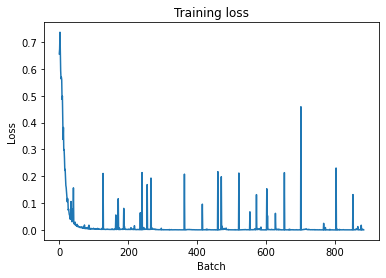

Loss на обучающей выборке: 0.01805
Процент правильных предсказаний на валидационной выборке: 99.81%


In [25]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [26]:
from sklearn.metrics import f1_score
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds) * 100
))
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 99.82%
Процент правильных предсказаний на валидационной выборке: 99.81%


In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [0]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [0]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [88]:
f1_score_v = f1_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    f1_score_v*100
))
c = 0
for i in range(len(test_labels)):
  if(test_labels[i]!=test_preds[i]):
    c+=1
print('Неправильных предсказаний: {0}/{1}'.format(
    c,
    len(test_labels)
))
print(c/len(test_labels))

Процент правильных предсказаний на отложенной выборке составил: 99.92%
Неправильных предсказаний: 12/13470
0.0008908685968819599


In [91]:
test_preds[0]

0

In [39]:
sum(test_labels)

7095

In [0]:
model.save_pretrained('./')

In [38]:
tokenizer.save_pretrained('./') 

('./vocab.txt', './special_tokens_map.json', './added_tokens.json')

In [40]:
logits

array([[-3.8086627,  4.5313616],
       [-3.5258   ,  4.2054653],
       [-3.561069 ,  4.317655 ],
       [-3.563194 ,  4.325587 ],
       [-3.7064922,  4.495109 ],
       [ 4.179145 , -4.714635 ],
       [ 4.2905445, -5.038616 ],
       [-3.7685366,  4.5364256],
       [-3.4967387,  4.1189966],
       [-3.6522775,  4.4362946],
       [-3.7513068,  4.500571 ],
       [ 4.338764 , -4.9653034],
       [-3.8130512,  4.455117 ],
       [ 4.251712 , -4.9945564],
       [ 4.3035636, -5.003175 ],
       [ 4.1718693, -4.7062683],
       [-3.559449 ,  4.2992945],
       [ 4.2797284, -4.972843 ],
       [-3.6949234,  4.3988414],
       [ 4.3325033, -5.0219936],
       [-3.8433743,  4.53025  ],
       [ 4.3159213, -5.010886 ],
       [ 4.237635 , -4.965848 ],
       [-2.7167652,  3.2438474],
       [ 4.306404 , -5.008828 ],
       [-3.7168272,  4.462761 ],
       [ 4.3273296, -5.072914 ],
       [-3.4867496,  4.2326417],
       [ 4.3097215, -4.933014 ],
       [-3.6409166,  4.3694515]], dtype=flo

In [43]:
test_preds[0:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [44]:
logits[0:10]

array([[-3.8086627,  4.5313616],
       [-3.5258   ,  4.2054653],
       [-3.561069 ,  4.317655 ],
       [-3.563194 ,  4.325587 ],
       [-3.7064922,  4.495109 ],
       [ 4.179145 , -4.714635 ],
       [ 4.2905445, -5.038616 ],
       [-3.7685366,  4.5364256],
       [-3.4967387,  4.1189966],
       [-3.6522775,  4.4362946]], dtype=float32)

In [95]:
def main(text):
  texts = []
  preds = []
  texts.append("[CLS] " + text[:509] + " [SEP]")
  print(texts)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in texts]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
  )
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
  
  prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks
  )

  prediction_dataloader = DataLoader(
      prediction_data, 
      sampler=SequentialSampler(prediction_data),
      batch_size=1
  )
  model.eval()
  preds = []

  for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1) 
    preds.extend(batch_preds)
  return preds
print(main('Why He Is Recognizing Jerusalem Today,"President Donald Trump announced yesterday that he plans to formally recognize Jerusalem as the capital of Israel. While this is left most pundits perplexed, the reasoning is clear. Trump wants to divert attention from Robert Mueller s investigation. It is no coincidence that the day after the news broke that Deutsche Bank has received subpoenas for information on the Trump family s assets, that this Jerusalem decision was announced. What could be a bigger news story than getting this information? A blow up in the Middle East.Look at the reaction world leaders have had to this announcement. American allies throughout the Middle East and Europe have asked Trump not to do this and have stressed how dangerous a statement this is. US News and World Report put this out today: The mere consideration of Trump changing the status quo sparked a renewed U.S. security warning on Tuesday. America s consulate in Jerusalem ordered U.S. personnel and their families to avoid visiting Jerusalem s Old City or the West Bank, and urged American citizens in general to avoid places with increased police or military presence. It is worth noting that while Trump will formally announce that the U.S. will recognize Jerusalem as Israel s capital, there is no movement underway to relocate the embassy from Tel Aviv. In fact, he has signed an order to delay that decision for another six months. This move is necessary due to the 1995 Jerusalem Embassy Act, which mandated the embassy be moved. It also allowed the president to delay that by six months and every president since that act became law has done so this way.The Atlantic has even compared this decision to Trump  wagging the dog,  a reference to a movie where a U.S. president goes to war with Albania to take the public s attention away from his own scandals involving a mistress. The film was viewed as a parody of President Bill Clinton s military actions in Afghanistan and Sudan after he acknowledged an affair with Monica Lewinsky.While whether or not Clinton attacked other countries to distract the nation from his actions with Lewinsky may be a point that is up for debate, it is clear that Trump likes to do things to distract the public s attention. Catherine Rampell wrote about this tactic late last year in the Washington Post. She wrote: Welcome to 2017, the ouroboros of distractions, where every terrible thing is a head-fake for a ruse for a diversion for a misdirection from something else much, much worse. Trump makes announcements, sends tweets and says things without any thought to the real world consequences that follow. Experts in the Middle East fear that the Jerusalem announcement will lead to real deaths. Many people worry  that his thoughtless and impetuous tweets will lead to a nuclear war. His thoughtless comments confuse and enrage many.By making such a move, for such purely personal reasons, Trump is proving, once again, that he is not fit to be president of a condo association, much less of the United States.Featured image by Andrew Burton/Getty Images'))

['[CLS] Why He Is Recognizing Jerusalem Today,"President Donald Trump announced yesterday that he plans to formally recognize Jerusalem as the capital of Israel. While this is left most pundits perplexed, the reasoning is clear. Trump wants to divert attention from Robert Mueller s investigation. It is no coincidence that the day after the news broke that Deutsche Bank has received subpoenas for information on the Trump family s assets, that this Jerusalem decision was announced. What could be a bigger news stor [SEP]']
[1]
